In [1]:
import pandas as pd

def train_test_split_time(df: pd.DataFrame, aus_port: str, for_port: str, test_length: int = 9):
    """
    Splits time-series data into train and test sets for a given city pair.

    Parameters:
        df: DataFrame with the dataset!
        aus_port: It refers to the Australian Port provided in the route.
        for_port: It refers to the Foreign Port provided in the route.
        horizon (int): Number of months to keep for testing. Kept as 9 (in between 6-12 months).
    """
    route_df = (df[((df["AustralianPort"] == aus_port) & (df["ForeignPort"] == for_port))]
                .sort_values("MonthYear").reset_index(drop=True))

    train = route_df.iloc[:-test_length]
    test = route_df.iloc[-test_length:]

    return train, test

In [3]:
df = pd.read_csv("../../data/aeroconnect_cleaned.csv")
train, test = train_test_split_time(df=df, aus_port="Sydney", for_port="Auckland")

print("Train range:", train["MonthYear"].min(), "→", train["MonthYear"].max())
print("Test range:", test["MonthYear"].min(), "→", test["MonthYear"].max())

Train range: 1985-01-01 → 1988-09-01
Test range: 1988-10-01 → 1989-06-01


In [4]:
def create_lag_features(series, n_lags=12):
    """
    This method prepares the input for time-series forecasting by creating "lag features". Each lag column corresponds to value of "PassengersTotal" from previous time-steps, which can be used as predictors for the current value.
    :param series: DataFrame.
    :param n_lags: Number of lagged time-steps to generate features for.
    :return: DataFrame with lag features!!
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df['PassengersTotal'].shift(lag)
    df = df.dropna()
    return df

In [25]:
df_lagged = create_lag_features(train[['PassengersTotal']], n_lags=12)

X = df_lagged.drop(columns=['PassengersTotal'])
y = df_lagged['PassengersTotal']

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [27]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=None):
    """
    Train a Random Forest model and evaluate it.

    Args:
        X_train, y_train: Training features/target
        X_test, y_test: Testing features/target
        n_estimators: Number of trees
        max_depth: Maximum depth of each tree (None = expand until pure)

    Returns:
        model: trained RandomForestRegressor
        metrics: dict with MAE, RMSE, Total Absolute Error, Accuracy %
    """
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    total_absolute_error = np.sum(np.abs(y_test - y_pred))
    accuracy_percent = round(100 - ((total_absolute_error / np.sum(y_test)) * 100), 2)

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "Total Absolute Error": total_absolute_error,
        "Accuracy %": accuracy_percent
    }

    return rf, metrics

In [28]:
rf_model, rf_metrics = train_random_forest(X_train, y_train, X_test, y_test)
print(rf_metrics)

{'MAE': 4457.801428571429, 'RMSE': np.float64(5066.241954504908), 'Total Absolute Error': np.float64(31204.61), 'Accuracy %': np.float64(92.95)}


In [33]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def plot_port_pair_forecast_rf(df, aus_port, foreign_port, n_lags=12, min_history=24, n_estimators=200, random_state=42):
    group = df[(df["AustralianPort"] == aus_port) & (df["ForeignPort"] == foreign_port)]
    group = group.sort_values("MonthYear")

    if len(group) < min_history:
        print(f"Not enough history for {aus_port}-{foreign_port}")
        return

    df_lags = create_lag_features(group['PassengersTotal'], n_lags=n_lags)
    if len(df_lags) < 2:
        print(f"Not enough lagged data for {aus_port}-{foreign_port}")
        return

    test_size = min(9, len(df_lags)//2)
    train = df_lags.iloc[:-test_size]
    test = df_lags.iloc[-test_size:]

    X_train = train.drop(columns='PassengersTotal').values
    y_train = train['PassengersTotal'].values
    X_test = test.drop(columns='PassengersTotal').values
    y_test = test['PassengersTotal'].values

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    plt.plot(group["MonthYear"].iloc[n_lags: -test_size], y_train, label="Train (Actual)", color="blue")
    plt.plot(group["MonthYear"].iloc[-test_size:], y_test, label="Test (Actual)", color="black", linestyle="dashed")
    plt.plot(group["MonthYear"].iloc[-test_size:], forecast, label="Forecast (RF)", color="red")

    plt.title(f"Passenger Forecast (Random Forest): {aus_port} → {foreign_port}")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

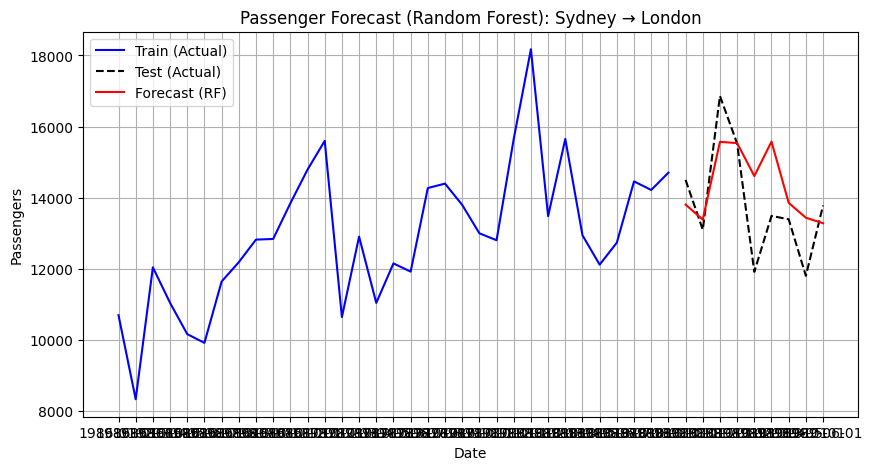

In [34]:
plot_port_pair_forecast_rf(df=df, aus_port="Sydney", foreign_port="London")